In [460]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

# Loss Functions

In [461]:
# F = lambda x: -3*(x+np.pi/2) if x <= -np.pi/2 else -3*np.cos(x) if -np.pi/2 < x <= np.pi/2 else -np.cos(x) + 2*x - np.pi
# F = lambda x: np.piecewise(x, [x <= -np.pi/2, (-np.pi/2 < x) and (x <= np.pi/2), x > np.pi/2],
#                         [lambda x: -3*(x+np.pi/2), lambda x: -3*np.cos(x), lambda x: -np.cos(x) + 2*x - np.pi])

def loss_function(x, y, equation):
    if equation == 0:
        return -3*x*x - y*y + 4*x*y
    elif equation == 1:
        return 3*x*x + y*y + 4*x*y
    elif equation == 2:
        return (4*x*x - (y-3*x+0.05*x**3)**2 - 0.1*y**4)*np.exp(-0.01*(x**2+y**2))
    elif equation == 3:
        return ((0.3*x*x + y)**2 + (0.1*y*y + x)**2)*np.exp(-0.01*(x**2+y**2))
    elif equation == 4:
        return np.log(1+np.exp(x)) + 3*x*y - np.log(1+np.exp(y))
    # elif equation == 5:
    #     return F(x) + 3*x*y - F(y)

# Gradient Descent Ascent

In [462]:
def GDA(x, y, lr, iter, equation):
    print('Gradient Descent Ascent: ')
    gda_vals = [[x, y, loss_function(x, y, equation)]]
    for _ in range(iter):
        grad_x, grad_y = grad(loss_function, (0,1))(x, y, equation)
        x = x - lr * grad_x
        y = y + lr * grad_y
        z = loss_function(x, y, equation)
        
        gda_vals.append([x, y, z])
    return gda_vals

# Alt-GDA

In [463]:
def AGDA(x, y, lr, iter, equation):
    print('Alternating Gradient Descent Ascent: ')
    agda_vals = [[x, y, loss_function(x, y, equation)]]
    for _ in range(iter):
        x = x - lr * grad(loss_function, 0)(x, y, equation)
        y = y + lr * grad(loss_function, 1)(x, y, equation)
        z = loss_function(x, y, equation)
        
        agda_vals.append([x, y, z])
    return agda_vals

# Optimistic GDA

In [464]:
def OGDA(x, y, lr, iter, equation):
    print('Optimistic Gradient Descent Ascent: ')
    x0, y0, x1, y1 = x, y, x-lr, y+lr
    ogda_vals = [[x, y, loss_function(x, y, equation)]]
    
    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_x0, grad_y0 = grad_f(x0, y0, equation)
        grad_x1, grad_y1 = grad_f(x1, y1, equation)

        x_new = x1 - 2*lr*grad_x1 + lr*grad_x0
        y_new = y1 + 2*lr*grad_y1 - lr*grad_y0

        x0, y0, x1, y1 = x1, y1, x_new, y_new
        z = loss_function(x1, y1, equation)

        ogda_vals.append([x1, y1, z])
    return ogda_vals

# Extragradient

In [465]:
def EG(x, y, lr, iter, equation):
    print('Extragradient: ')
    eg_vals = [[x, y, loss_function(x, y, equation)]]
    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_x, grad_y = grad_f(x, y, equation)

        x_temp = x - lr*grad_x
        y_temp = y + lr*grad_y
        grad_x_temp, grad_y_temp = grad_f(x_temp, y_temp, equation)

        x = x - lr * grad_x_temp
        y = y + lr * grad_y_temp
        z = loss_function(x, y, equation)
        
        eg_vals.append([x, y, z])
    return eg_vals

In [466]:
def hessian(loss_function, x, y, equation):
    grad_grad_fx = grad(grad(loss_function, 0), (0,1))
    grad_grad_fy = grad(grad(loss_function, 1), (0,1))
    return np.asarray((grad_grad_fx(x, y, equation), grad_grad_fy(x, y, equation)))

# Symplectic Gradient Adjustment

In [467]:
def SGA(x, y, lr, iter, equation):
    print('Symplectic Gradient Adjustment: ')
    lamda = 1
    sga_vals = [[x, y, loss_function(x, y, equation)]]
    
    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y, equation)
        hess = hessian(loss_function, x, y, equation)

        x = x - lr*grad_fx - lr*lamda*hess[0][1]*grad_fy
        y = y + lr*grad_fy - lr*lamda*hess[1][0]*grad_fx
        z = loss_function(x, y, equation)

        sga_vals.append([x, y, z])
    return sga_vals

# Concensus Optimization

In [468]:
def CO(x, y, lr, iter, equation):
    print('Concensus Optimization: ')
    gamma = 0.1 # 0.01, 0.03, 0.1, 0.3, 1, 3, 10 
    co_vals = [[x, y, loss_function(x, y, equation)]]

    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y, equation)
        grad_fxy = np.asarray((grad_fx, grad_fy))

        # ∇||∇f(x,y)||^2 = 2*∇(∇f(x,y))*∇f(x,y) = 2*(H(f(x,y)).∇f(x,y))
        hess = hessian(loss_function, x, y, equation)
        grad_fnorm_squared_x, grad_fnorm_squared_y = 2 * np.dot(hess, grad_fxy)
        
        x = x - lr*grad_fx - gamma*lr*grad_fnorm_squared_x
        y = y + lr*grad_fy - gamma*lr*grad_fnorm_squared_y
        z = loss_function(x, y, equation)
        
        co_vals.append([x, y, z])
    return co_vals

# Unrolled SGD 
#### (Rectify this)

In [469]:
def USGD(x, y, lr, iter, equation):
    print('Unrolled SGD: ')
    usgd_vals = [[x, y, loss_function(x, y, equation)]]

    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y, equation)

        grad_yx = grad(loss_function, 0)(y, x, equation)
        grad_xy = grad(loss_function, 1)(y, x, equation)
        # Dunno how to calculate ∇ₓyₖ and ∇ᵧxₖ

        x = x - lr * (grad_fx + grad_yx)
        y = y - lr * (-grad_fy + grad_xy)
        z = loss_function(x, y, equation)
        
        usgd_vals.append([x, y, z])
    return 0

# Follow the Ridge

In [470]:
def FR(x, y, lr, iter, equation):
    print('Follow the Ridge: ')
    # lr_x, lr_y = lr, lr/4
    lr_x, lr_y = lr, lr
    fr_vals = [[x, y, loss_function(x, y, equation)]]
    
    for _ in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y, equation) 
        hess = hessian(loss_function, x, y, equation)

        x = x - lr_x * grad_fx
        y = y + lr_y*grad_fy + lr_x*(1/hess[1][1])*hess[1][0]*grad_fx
        z = loss_function(x, y, equation)
        
        fr_vals.append([x, y, z])
    return fr_vals

# Gradient Minimization Network

The commented code is the code that I have written to implement the algorithm. The code below is the original code from the paper that was shown in the video.\
These are the number of iterartions taken for convergence : My algo-[26, 168, 23] vs YT algo-[30, X, 18]\
My code converges in equation 1 too.

In [471]:
def GMN(x, y, lr, iter, equation):
    print('Gradient Minimization Network: ')
    k = 5 # {5, 10, 25, 50}
    gmn_vals = [[x, y, loss_function(x, y, equation)]]
    
    # Different LR at kth iter and iter'th iter
    for _ in range(iter):
        x_w, y_w = x, y 
        for _ in range(k):
            grad_xw = grad(loss_function, 0)(x_w, y, equation)
            grad_yw = grad(loss_function, 1)(x, y_w, equation)
            x_w = x_w - lr*grad_xw
            y_w = y_w + lr*grad_yw

        DG = lambda x_,y_,equation: loss_function(x_, y_w, equation) - loss_function(x_w, y_, equation)
        grad_x, grad_y = grad(DG, (0,1))(x,y,equation)
        x = x - lr * grad_x
        y = y - lr * grad_y
        z = loss_function(x, y, equation)
        
        gmn_vals.append([x, y, z])
    return gmn_vals

    # DG = lambda x_,y_,equation: abs(loss_function(x_, y_min, equation) - loss_function(x_max, y_, equation))
    # for _ in range(iter):
    #     for _ in range(k):
    #         grad_xw, grad_yw = grad(loss_function, (0,1))(x, y, equation)
    #         y_min = y - lr * grad_yw # minimizing y
    #         x_max = x + lr * grad_xw # maximizing x

    #     grad_x, grad_y = grad(DG, (0,1))(x, y, equation)
    #     x = x - lr * grad_x
    #     y = y - lr * grad_y
    #     z = loss_function(x,y,equation)

    #     gmn_vals.append([x, y, z])
    # return gmn_vals

# Convergence Analysis

In [472]:
import os
if not os.path.exists('vals'):
    os.makedirs('vals')

def check_convergence(vals, filename, equation, x, y):
    with open(f'vals/{filename}_{equation}.txt', 'w') as f:
        f.write(f'seed at x: {x} y: {y}, with equation {equation}\n')
        for item in vals:
            f.write(f'x: {round(item[0], 5)} y: {round(item[1], 5)} z: {round(item[2], 5)}\n')

        for i in range(len(vals)-1):
            if abs(round(vals[i][0],5) - round(vals[i+1][0],5)) == 0\
                and abs(round(vals[i][1],5) - round(vals[i+1][1],5)) == 0:
                f.write(f'Converged at iteration {i+1} at f({round(vals[i][0], 5)}, {round(vals[i][1], 5)}) = {round(vals[i][2], 5)}')
                print(f'\tConverged at iteration {i+1} at f({round(vals[i][0], 5)}, {round(vals[i][1], 5)}) = {round(vals[i][2], 5)}')
                return [filename, vals]
        
        f.write('Did not converge')
        print('\tDid not converge') 
    return [filename, vals]

# Plot the Paths

In [473]:
# Plot the loss function as contour and the path taken by each algorithm
def plot_paths(vals, equation, xlims, ylims):
    X = np.linspace(xlims[0], xlims[1], 100)
    Y = np.linspace(ylims[0], ylims[1], 100)
    X, Y = np.meshgrid(X, Y)
    Z = loss_function(X, Y, equation)
    fig, ax = plt.subplots(1, 1)
    ax.contourf(X, Y, Z, 30, cmap=cm.coolwarm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Loss Function Contour')

    cbar = fig.colorbar(mappable=ax.contourf(X, Y, Z, 30, cmap=cm.coolwarm), ax=ax)
    cbar.ax.set_ylabel('Loss', rotation=-90, va="bottom")

    path = ['b--', 'k--', 'c--', 'y--', 'm--', 'g--', 'w--', 'r--']
    for i in vals:
        val = np.asarray(i[1])
        ax.plot(val[:,0], val[:,1], path.pop(), label=i[0].upper())

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.legend()
    plt.show()

# Plot the 3D surface

In [474]:
# Plot the 3D surface of the loss function and the path taken by each algorithm
def plot_3d(vals, equation, xlims, ylims, zlims):
    X = np.linspace(xlims[0], xlims[1], 1000)
    Y = np.linspace(ylims[0], ylims[1], 1000)
    X, Y = np.meshgrid(X, Y)
    Z = loss_function(X, Y, equation)
    
    # fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
    # path = ['blue', 'black', 'cyan', 'yellow', 'magenta', 'green', 'white', 'red']
    # for i in vals:
    #     val = np.asarray(i[1])
    #     fig.add_trace(go.Scatter3d(x=val[:,0], y=val[:,1], z=val[:,2], mode='lines',
    #                                line=dict(color=path.pop()), name=i[0].upper()))
    
    # fig.update_layout(scene = dict(xaxis=dict(range=xlims),
    #                                yaxis=dict(range=ylims),
    #                                zaxis=dict(range=zlims)),
    #                     autosize=False, width=500, height=500)

    # fig.show()

    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.35, edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Loss Function Surface')

    path = ['b--', 'k--', 'c--', 'y--', 'm--', 'g--', 'w--', 'r--']
    for i in vals:
        val = np.asarray(i[1])
        ax.plot(val[:,0], val[:,1], val[:,2], path.pop(), label=i[0].upper())

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.legend()
    plt.show()

# Plot convergence

In [475]:
# Plot loss vs iteration for each algorithm in the same plot but different subplots
# ax.plot(usgd_vals[:,2], 'w--', label='USGD')

def plot_loss(vals, lims):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_title('Loss vs Iteration')

    path = ['b--', 'k--', 'c--', 'y--', 'm--', 'g--', 'w--', 'r--']
    for i in vals:
        val = np.asarray(i[1])
        ax.plot(val[:,2], path.pop(), label=i[0].upper())

    ax.legend()
    ax.set_ylim(lims)
    plt.show()

# Main Code


Equation 0: -3x^2 - y^2 + 4xy
Gradient Descent Ascent: 
	Did not converge
Alternating Gradient Descent Ascent: 
	Did not converge
Optimistic Gradient Descent Ascent: 
	Did not converge
Extragradient: 
	Did not converge
Symplectic Gradient Adjustment: 
	Converged at iteration 85 at f(2e-05, 4e-05) = 0.0
Concensus Optimization: 
	Did not converge
Follow the Ridge: 
	Converged at iteration 141 at f(3e-05, 6e-05) = 0.0
Gradient Minimization Network: 
	Converged at iteration 102 at f(2e-05, 4e-05) = 0.0


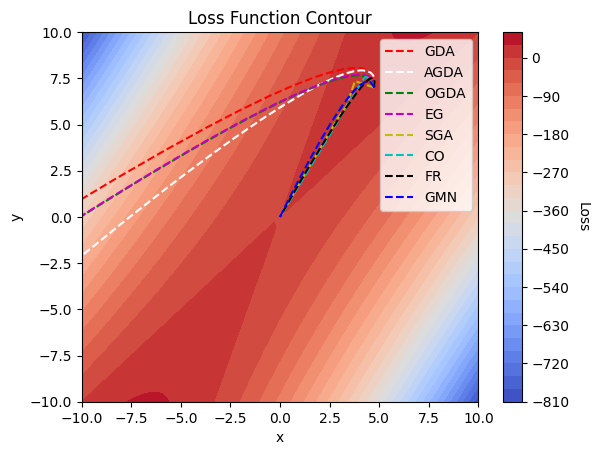

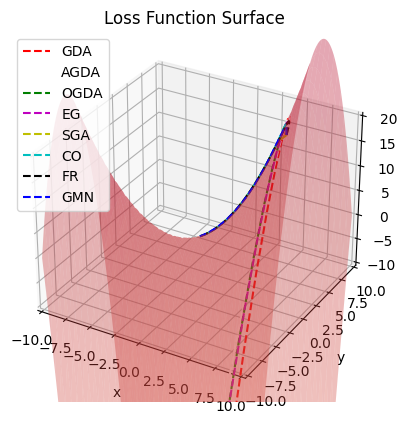

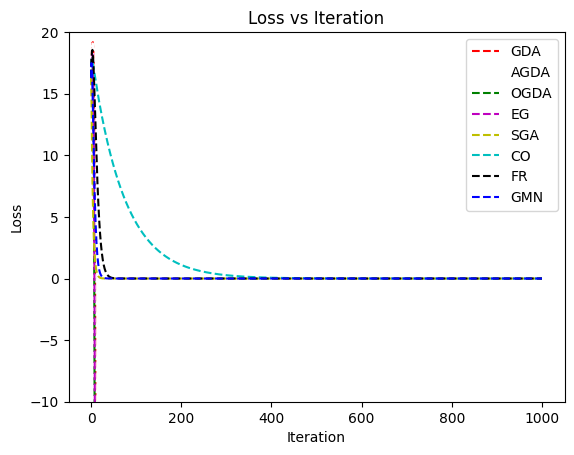


Equation 1: 3x^2 + y^2 + 4xy
Gradient Descent Ascent: 
	Converged at iteration 151 at f(-5e-05, 5e-05) = -0.0
Alternating Gradient Descent Ascent: 
	Converged at iteration 218 at f(-9e-05, 0.00011) = -0.0
Optimistic Gradient Descent Ascent: 
	Converged at iteration 165 at f(-6e-05, 6e-05) = -0.0
Extragradient: 
	Converged at iteration 168 at f(-5e-05, 5e-05) = -0.0
Symplectic Gradient Adjustment: 
	Converged at iteration 98 at f(-3e-05, 5e-05) = -0.0
Concensus Optimization: 
	Converged at iteration 449 at f(-0.00019, 0.00029) = -0.0
Follow the Ridge: 
	Did not converge
Gradient Minimization Network: 
	Converged at iteration 315 at f(-0.00017, 0.00027) = -0.0


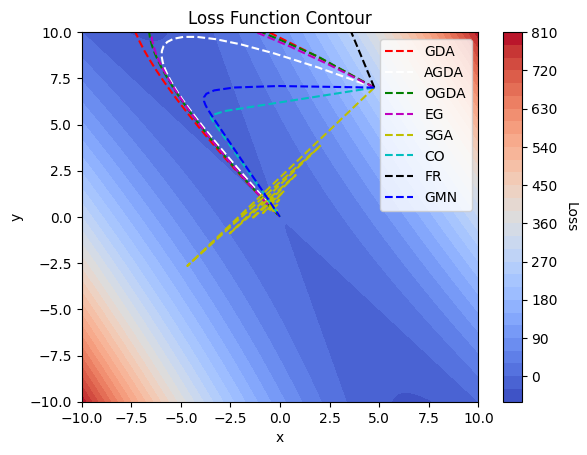

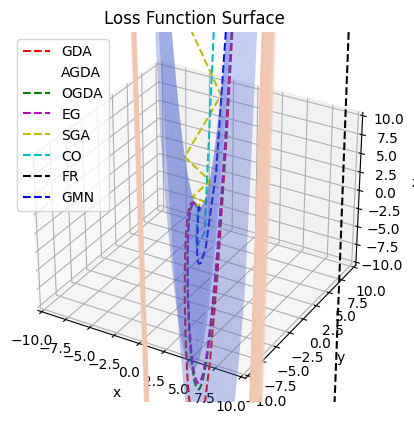

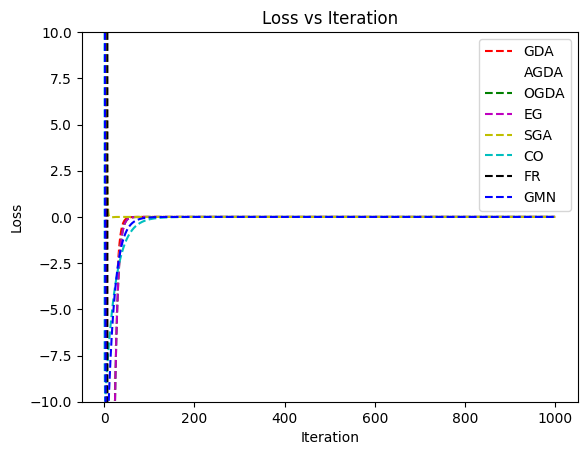


Equation 2: (4x^2 - (y-3x+0.05x^3)^2 - 0.1y^4)*e^(-0.01(x^2+y^2))
Gradient Descent Ascent: 
	Did not converge
Alternating Gradient Descent Ascent: 
	Did not converge
Optimistic Gradient Descent Ascent: 
	Did not converge
Extragradient: 
	Did not converge
Symplectic Gradient Adjustment: 
	Converged at iteration 10 at f(33.86989, -120.53849) = -0.0
Concensus Optimization: 
	Converged at iteration 848 at f(0.7512, 1.37951) = 1.13916
Follow the Ridge: 
	Converged at iteration 128 at f(-3e-05, -6e-05) = 0.0
Gradient Minimization Network: 
	Converged at iteration 91 at f(0.0, 1e-05) = 0.0


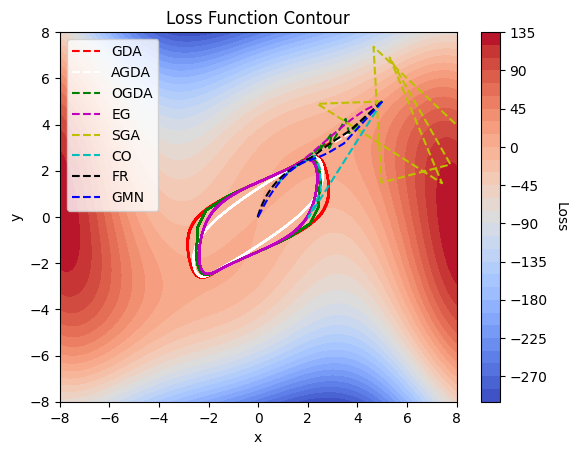

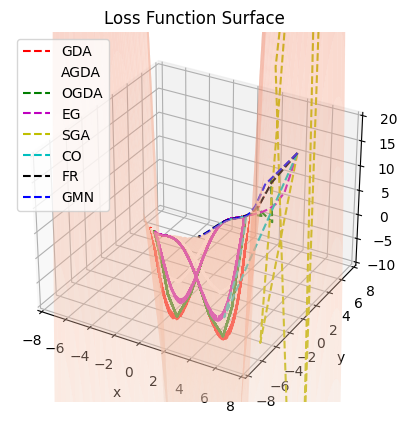

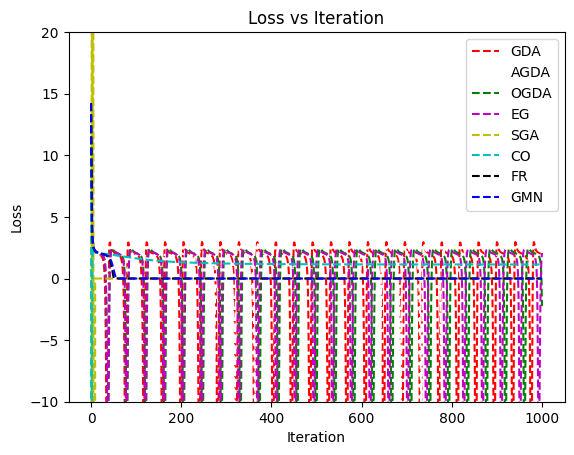


Equation 3: ((0.3x^2 + y)^2 + (0.1y^2 + x)^2)*e^(-0.01(x^2+y^2))
Gradient Descent Ascent: 
	Converged at iteration 87 at f(-2.59606, 12.41331) = 74.59423
Alternating Gradient Descent Ascent: 
	Converged at iteration 88 at f(-2.59607, 12.41333) = 74.59423
Optimistic Gradient Descent Ascent: 
	Converged at iteration 98 at f(-2.59608, 12.41334) = 74.59423
Extragradient: 
	Converged at iteration 95 at f(-2.5961, 12.41335) = 74.59423
Symplectic Gradient Adjustment: 
	Converged at iteration 63 at f(-2.59604, 12.41336) = 74.59423
Concensus Optimization: 
	Converged at iteration 56 at f(-2.59603, 12.41335) = 74.59423
Follow the Ridge: 
	Converged at iteration 91 at f(-2.59597, 12.41329) = 74.59423
Gradient Minimization Network: 
	Converged at iteration 79 at f(-2.59599, 12.41332) = 74.59423


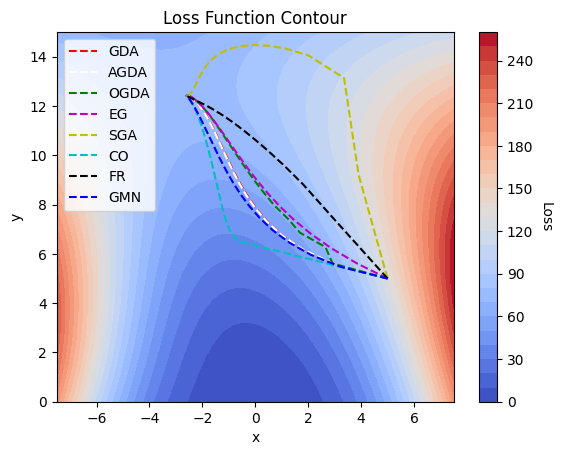

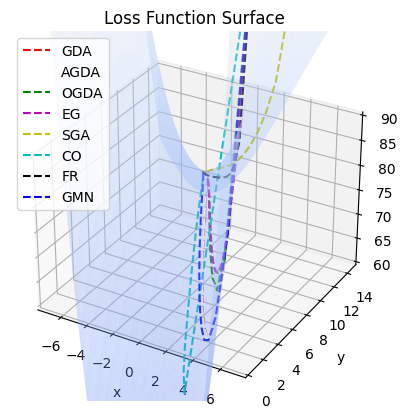

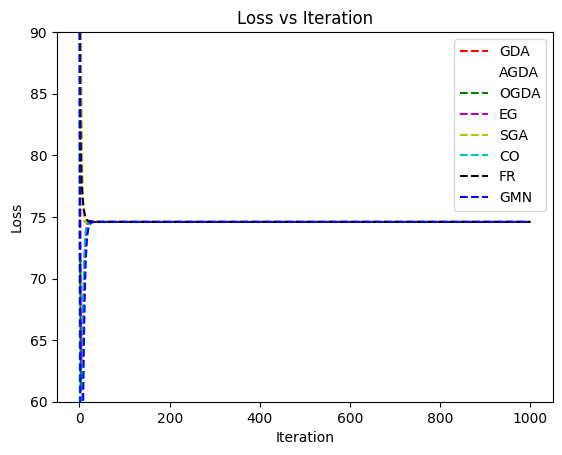


Equation 4: ln(1+e^x) + 3xy - ln(1+e^y)
Gradient Descent Ascent: 
	Did not converge
Alternating Gradient Descent Ascent: 
	Converged at iteration 998 at f(0.15183, -0.17924) = 0.08276
Optimistic Gradient Descent Ascent: 
	Converged at iteration 495 at f(0.15182, -0.1793) = 0.08276
Extragradient: 
	Converged at iteration 500 at f(0.15182, -0.17925) = 0.08276
Symplectic Gradient Adjustment: 
	Converged at iteration 24 at f(0.15177, -0.17929) = 0.08276
Concensus Optimization: 
	Converged at iteration 130 at f(0.15173, -0.1793) = 0.08276
Follow the Ridge: 
	Did not converge
Gradient Minimization Network: 
	Converged at iteration 104 at f(0.15177, -0.17933) = 0.08276


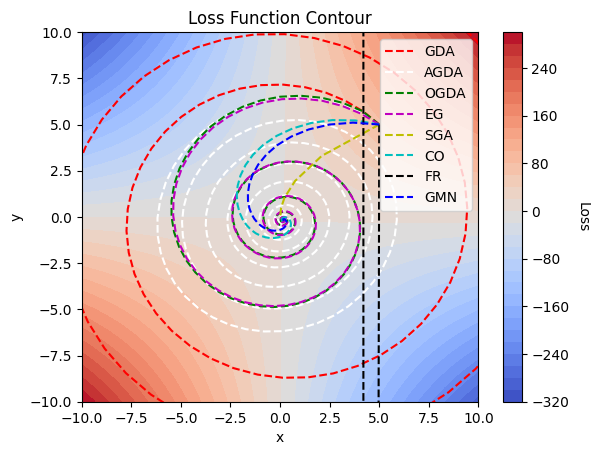

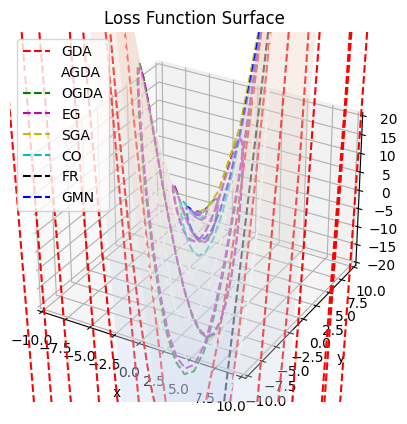

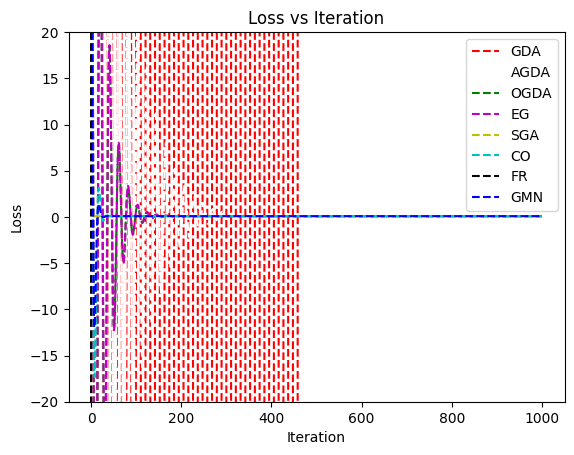

In [476]:
equations = ['-3x^2 - y^2 + 4xy', '3x^2 + y^2 + 4xy',
             '(4x^2 - (y-3x+0.05x^3)^2 - 0.1y^4)*e^(-0.01(x^2+y^2))',
             '((0.3x^2 + y)^2 + (0.1y^2 + x)^2)*e^(-0.01(x^2+y^2))',
             'ln(1+e^x) + 3xy - ln(1+e^y)']
seeds = [[4.75,7.0], [4.75,7.0], [5.0,5.0], [5.0,5.0], [5.0,5.0]]
lims = [[[-10, 10], [-10, 10]],
        [[-10, 10], [-10, 10]],
        [[-8, 8], [-8, 8]],
        [[-7.5, 7.5], [0, 15]],
        [[-10, 10], [-10, 10]]]

# seeds = [[1.5,0.5], [1.5,0.5], [1.5,0.5], [5.0,5.0], [5.0,5.0]]
# lims = [[[-5, 5], [-5, 5]],
#         [[-5, 5], [-5, 5]],
#         [[-5, 5], [-5, 5]],
#         [[-7.5, 7.5], [0, 15]],
#         [[-10, 10], [-10, 10]]]

iter = 1000
loss_lims = [[-10, 20], [-10, 10], [-10, 20], [60, 90], [-20, 20]]

for i in range(len(equations)):
    x, y = seeds[i]
    lr = 0.05
    equation = i
    xlims, ylims = lims[i]
    llims = loss_lims[i]
    vals = []

    print(f'\nEquation {i}: {equations[i]}')
    gda_vals = GDA(x, y, lr, iter, equation)
    vals.append(check_convergence(gda_vals, 'gda', equation, x, y))
    agda_vals = AGDA(x, y, lr, iter, equation)
    vals.append(check_convergence(agda_vals, 'agda', equation, x, y))
    ogda_vals = OGDA(x, y, lr, iter, equation)
    vals.append(check_convergence(ogda_vals, 'ogda', equation, x, y))
    eg_vals = EG(x, y, lr, iter, equation)
    vals.append(check_convergence(eg_vals, 'eg', equation, x, y))
    sga_vals = SGA(x, y, lr, iter, equation)
    vals.append(check_convergence(sga_vals, 'sga', equation, x, y))
    co_vals = CO(x, y, lr, iter, equation)
    vals.append(check_convergence(co_vals, 'co', equation, x, y))
    # usgd_vals = USGD(x, y, lr, iter, equation)
    # vals.append(check_convergence(usgd_vals, 'usgd', equation, x, y))
    fr_vals = FR(x, y, lr, iter, equation)
    vals.append(check_convergence(fr_vals, 'fr', equation, x, y))
    gmn_vals = GMN(x, y, lr, iter, equation)
    vals.append(check_convergence(gmn_vals, 'gmn', equation, x, y))

    plot_paths(vals, equation, xlims, ylims)
    plot_3d(vals, equation, xlims, ylims, llims)
    plot_loss(vals, llims)